In [46]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt


# Descarga de datos
tickers = ["KVUE","JPM","CDNS","PANW"]
weights = np.array([0.4,0.2,0.3,0.1])

end = dt.datetime.today()
start = end - dt.timedelta(days=365*3)

data = yf.download(tickers,start=start,end=end)["Close"]
returns = data.pct_change().dropna()

n_sim = 1000
n_days = 252
n_assets = len(tickers)

[*********************100%***********************]  4 of 4 completed


In [47]:
lambda_ = 0.94

ewma_var = returns.var().copy()
ewma_vol_series = []

for t in range(len(returns)):
    r_t = returns.iloc[t]
    ewma_var = lambda_ * ewma_var + (1 - lambda_) * (r_t ** 2)
    ewma_vol_series.append(np.sqrt(ewma_var))

ewma_vol_df = pd.DataFrame(ewma_vol_series, 
                           index=returns.index, 
                           columns=returns.columns)

In [48]:
corr_matrix = returns.corr()
L_corr = np.linalg.cholesky(corr_matrix)

In [49]:
sigma_t = ewma_vol_df.iloc[-1].values
portfolio_paths = np.zeros((n_sim,n_days))

for s in range(n_sim):

    sigma = sigma_t.copy()
    prices_sim = np.ones(n_assets)

    for t in range(n_days):

        z = np.random.normal(size=n_assets)
        correlated = L_corr @ z

        r = sigma * correlated

        prices_sim = prices_sim * (1 + r)

        port_ret = np.dot(weights, r)

        if t == 0:
            portfolio_paths[s, t] = 1 + port_ret
        else:
            portfolio_paths[s, t] = portfolio_paths[s, t-1] * (1 + port_ret)

        sigma = np.sqrt(lambda_ * sigma**2 + (1 - lambda_) * (r**2))

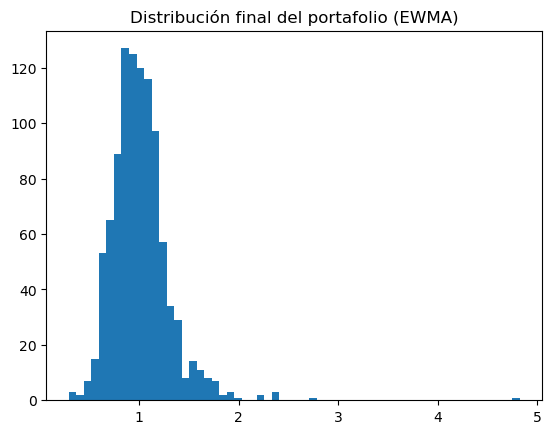

VaR 95%: 0.37171285238062834
Expected Shortfall 95%: 0.4442731236808677


In [50]:
final_values = portfolio_paths[:,-1]

plt.hist(final_values,bins=60)
plt.title("Distribución final del portafolio (EWMA)")
plt.show()

var_95 = np.percentile(final_values,5)
es_95 = final_values[final_values<=var_95].mean()

print("VaR 95%:",1-var_95)
print("Expected Shortfall 95%:",1-es_95)

In [51]:
prices_all = yf.download(tickers, start=start, end=end, progress=False)["Close"].dropna()
returns_all = prices_all.pct_change().dropna()

### Actividad

In [55]:
tickers = ["KVUE", "JPM", "OWL", "PANW"]
weights = np.array([0.4, 0.2, 0.3, 0.1], dtype=float)

n_sim = 10000
horizon_days = 15
np.random.seed(42)

end = dt.datetime.today()
start = end - dt.timedelta(days=365*10)

def normalize_weights(w):
    w = np.array(w, dtype=float)
    return w / w.sum()

def slice_by_years(returns_df, years):
    last_date = returns_df.index.max()
    start_date = last_date - pd.DateOffset(years=years)
    out = returns_df.loc[returns_df.index >= start_date].dropna()
    return out

def var95_percent(final_values):
    loss_pct = (1.0 - final_values) * 100.0
    return np.percentile(loss_pct, 95)

def robust_cholesky_from_corr(corr, jitter=1e-10, max_tries=8):
    """
    Devuelve L tal que L L' ~ corr.
    1) Intenta cholesky directo
    2) Si falla, agrega jitter creciente a la diagonal
    3) Si falla, proyecta a PSD (eigenvalue clipping) y luego cholesky
    """
    corr = np.array(corr, dtype=float)

    for k in range(max_tries):
        try:
            return np.linalg.cholesky(corr + (10**k) * jitter * np.eye(corr.shape[0]))
        except np.linalg.LinAlgError:
            pass

    vals, vecs = np.linalg.eigh(corr)
    vals_clipped = np.clip(vals, 1e-8, None)
    corr_psd = (vecs * vals_clipped) @ vecs.T

    d = np.sqrt(np.diag(corr_psd))
    corr_psd = corr_psd / np.outer(d, d)

    return np.linalg.cholesky(corr_psd + 1e-10 * np.eye(corr_psd.shape[0]))

raw = yf.download(tickers, start=start, end=end, progress=False)

if isinstance(raw.columns, pd.MultiIndex):
    close = raw["Close"].copy()
else:
    close = raw.copy()

close = close.dropna(how="all")

valid_tickers = [t for t in close.columns if close[t].notna().sum() > 20]  # al menos 20 datos
if len(valid_tickers) < len(tickers):
    bad = set(tickers) - set(valid_tickers)
    print("Tickers eliminados por datos insuficientes:", bad)

valid_idx = [tickers.index(t) for t in valid_tickers]
weights_valid = normalize_weights(weights[valid_idx])

prices_all = close[valid_tickers].dropna()
returns_all = prices_all.pct_change().dropna()

def var_mgb_constant_vol(returns_hist, weights, n_sim=10000, horizon_days=15):
    logret = np.log1p(returns_hist).dropna()
    mu = logret.mean().values
    sigma = logret.std(ddof=1).values

    corr = logret.corr().values
    L = robust_cholesky_from_corr(corr)

    final_values = np.zeros(n_sim)

    for s in range(n_sim):
        port_val = 1.0
        for _ in range(horizon_days):
            z = np.random.normal(size=len(weights))
            correlated = L @ z
            lr = mu + sigma * correlated
            asset_ret = np.expm1(lr)
            port_ret = np.dot(weights, asset_ret)
            port_val *= (1.0 + port_ret)
        final_values[s] = port_val

    return var95_percent(final_values)

# ========= EWMA =========
def ewma_last_sigma(returns_hist, lam):
    ewma_var = returns_hist.var().copy()
    for t in range(len(returns_hist)):
        r_t = returns_hist.iloc[t]
        ewma_var = lam * ewma_var + (1 - lam) * (r_t ** 2)
    return np.sqrt(ewma_var).values

def var_ewma(returns_hist, weights, lam, n_sim=10000, horizon_days=15):
    corr = returns_hist.corr().values
    L = robust_cholesky_from_corr(corr)

    sigma_init = ewma_last_sigma(returns_hist, lam)

    final_values = np.zeros(n_sim)

    for s in range(n_sim):
        sigma = sigma_init.copy()
        port_val = 1.0
        for _ in range(horizon_days):
            z = np.random.normal(size=len(weights))
            correlated = L @ z
            r = sigma * correlated
            port_ret = np.dot(weights, r)
            port_val *= (1.0 + port_ret)
            sigma = np.sqrt(lam * (sigma ** 2) + (1 - lam) * (r ** 2))
        final_values[s] = port_val

    return var95_percent(final_values)

years_list = [1, 3, 5, 10]
results = []

for yrs in years_list:
    hist = slice_by_years(returns_all, yrs)
    results.append({
        "Proceso": "MGB vol constante",
        "Años_hist": yrs,
        "Lambda": np.nan,
        "VaR_95_% (15d)": var_mgb_constant_vol(hist, weights_valid, n_sim, horizon_days)
    })

for yrs in years_list:
    hist = slice_by_years(returns_all, yrs)
    results.append({
        "Proceso": "EWMA",
        "Años_hist": yrs,
        "Lambda": 0.94,
        "VaR_95_% (15d)": var_ewma(hist, weights_valid, 0.94, n_sim, horizon_days)
    })

for yrs in years_list:
    hist = slice_by_years(returns_all, yrs)
    results.append({
        "Proceso": "EWMA",
        "Años_hist": yrs,
        "Lambda": 0.8,
        "VaR_95_% (15d)": var_ewma(hist, weights_valid, 0.8, n_sim, horizon_days)
    })

results_df = pd.DataFrame(results).sort_values(
    by=["Proceso", "Lambda", "Años_hist"],
    na_position="first"
).reset_index(drop=True)

pd.options.display.float_format = "{:,.4f}".format
print("\n=== Tabla comparativa: VaR 15 días al 95% (en %) ===")
print("Tickers usados:", valid_tickers)
print("Pesos usados:", weights_valid)
print(results_df)


=== Tabla comparativa: VaR 15 días al 95% (en %) ===
Tickers usados: ['JPM', 'KVUE', 'OWL', 'PANW']
Pesos usados: [0.2 0.4 0.3 0.1]
              Proceso  Años_hist  Lambda  VaR_95_% (15d)
0                EWMA          1  0.8000         10.0802
1                EWMA          3  0.8000          9.6587
2                EWMA          5  0.8000          9.6432
3                EWMA         10  0.8000          9.5733
4                EWMA          1  0.9400          9.7692
5                EWMA          3  0.9400          9.3035
6                EWMA          5  0.9400          9.1490
7                EWMA         10  0.9400          9.2824
8   MGB vol constante          1     NaN         11.3249
9   MGB vol constante          3     NaN          7.4341
10  MGB vol constante          5     NaN          7.4070
11  MGB vol constante         10     NaN          7.3328
